In [290]:
import os
import numpy as np
import numpy.random as npr
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
#plt.switch_backend('agg')

from scipy.integrate import odeint

keras = tf.keras
tf.compat.v1.enable_eager_execution()

#from neural_ode import NeuralODE

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [427]:
def SIR(z, t, beta, gamma):

    S, I, R = z

    dS = - beta * I * S / N 
    dI = beta * I * S / N - gamma * I
    dR = gamma * I 

    dzdt = [dS, dI, dR]
    return dzdt
    
def SIR_diffparam(z, t, beta, beta2, gamma, gamma2, errato = 0):

    S, I, R = z

    dS = - beta * I * S / N 
    dI = beta2 * I * S / N - gamma * I
    dR = gamma2 * I 

    dzdt = [dS, dI, dR]
    return dzdt


def plot_traj(trajectories, width = 1.):
    #x1 = trajectories[:,0]
    x2 = trajectories[:,1]
    x3 = trajectories[:,2]
    #s = plt.plot(x1, linewidth = width, label = 'Susceptible')
    i = plt.plot(x2, linewidth = width, label = 'Infected')
    r = plt.plot(x3, linewidth = width, label = 'Removed')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title('Real shit')
    
    
def plot_traj_gray(trajectories, width = 1.):
    #x1 = trajectories[:,0]
    x2 = trajectories[:,1]
    x3 = trajectories[:,2]
    #s = plt.plot(x1, linewidth = width, color = 'lightgray')
    i = plt.plot(x2, linewidth = width, color = 'lightgray')
    r = plt.plot(x3, linewidth = width, color = 'lightgray')

In [428]:
italy = pd.read_csv('Data/Sird.csv')
reduce = 1

In [429]:
if reduce:
    italy = italy[30:]
    italy.reset_index(inplace = True, drop = True)
    italy

In [1]:
data_size = italy.shape[0]

batch_time = 20 # tempo delle batches
niters = 500
batch_size = data_size - batch_time - 1

N = 60317316

for i in range(data_size):
    if not i:
        italy['Susceptible'] = N
    else:
        italy.loc[i,'Susceptible'] = italy.iloc[i-1]['Susceptible'] - italy.iloc[i-1]['Recovered'] #- italy.iloc[i-1]['Dead'] 
        
true_y = []
for i in range(data_size):
    true_y.append([italy.loc[i,'Susceptible'],italy.loc[i,'Infected'],italy.loc[i,'Recovered']])
true_y = np.array(true_y)

nonorm_y = true_y.copy()

NameError: name 'italy' is not defined

In [ ]:
plot_traj(true_y)

In [ ]:
from scipy import integrate, optimize

true_yy = np.append(true_y[:,0],true_y[:,1])
true_yy = np.append(true_yy,true_y[:,2])

def fit_odeint(x, beta, gamma):
    fit = integrate.odeint(SIR, (N,704,909), x, args=(beta, gamma))
    fit_p = np.append(fit[:,0],fit[:,1])
    return np.append(fit_p,fit[:,2])

popt, pcov = optimize.curve_fit(fit_odeint, xdata = t_grid, ydata =  true_yy)

popt, pcov

In [2]:
simul_yy =  odeint(SIR, [N,704,909], t_grid, args=tuple(np.reshape(popt,(1,-1))[0]))
plot_traj(simul_yy)
plot_traj_gray(nonorm_y)

NameError: name 'odeint' is not defined

In [3]:
sigma_s = np.std(true_y[:,0:1])  
sigma_i = np.std(true_y[:,1:2]) 
sigma_r = np.std(true_y[:,2:3]) 

true_y[:, 0:1] = true_y[:, 0:1]/sigma_s
true_y[:, 1:2] = true_y[:, 1:2]/sigma_i
true_y[:, 2:3] = true_y[:, 2:3]/sigma_r

# mmm mi sa che c'è troppa differenza

NameError: name 'np' is not defined

In [4]:
plot_traj(true_y)

NameError: name 'plot_traj' is not defined

In [298]:
def get_batch():
    """Returns initial point and last point over sampled frament of trajectory"""
    starts = np.random.choice(np.arange(data_size - batch_time - 1, dtype=np.int64), batch_size, replace=False)
    # This randomly chooses from {0, 1, ... , data_size - batch_time - 1}, batch_size different elements
    batch_y0 = true_y[starts] 
    batch_yN = true_y[starts + batch_time]
    # The function returns a tensor composed by some y0 and the respective yN,
    # being y0 + DeltaT.
    return tf.cast(batch_y0, dtype=tf.float32), tf.cast(batch_yN, dtype=tf.float32)

In [299]:
italy['Date'] = pd.to_datetime(italy['Date'])

t_grid = np.arange(data_size)

In [300]:
num_param = 2 # Number of parameters
para_num = num_param

t0 = t_grid[:batch_time][0]  # t0 = first element of t_grid
t1 = t_grid[:batch_time][-1]  # t1 = the element of t_grid at batch_time
t_in = np.linspace(t0, t1, 10)  # The time grid between t0 and t1

batch_y0, batch_yN = get_batch()  # Returns the first and the last y observed for each batch


In [301]:
from neural_ode import NeuralODE

niters_pre = 200  # Number of iterations of the preconditioner

class ODEModel_pre(tf.keras.Model):
    def __init__(self):
        super(ODEModel_pre, self).__init__()
        self.Weights = tf.Variable(tf.random.normal([num_param, 1], dtype=tf.float32)*0.01, dtype=tf.float32)
    # Initializer: assign normally distributed random weights which are very close to zero

    def call(self, inputs, **kwargs):
        t, y = inputs
        h = y
        S = h[:, 0:1] * sigma_s
        I = h[:, 1:2] * sigma_i
        R = h[:, 2:3] * sigma_r

        # ma che sintassi di merda -> facciamolo adattativo

        p1 = self.Weights[0]
        p2 = self.Weights[1]
        
        dS = - p1 * I * S / N 
        dI = p1 * I * S / N - p2 * I 
        dR = p2 * I 

        dzdt = [dS, dI, dR]
        
        h_out = tf.concat([dS/sigma_s, dI/sigma_i, dR/sigma_r], 1)
        #h_out = tf.concat([dS, dI, dR], 1)
        return h_out


model_pre = ODEModel_pre()  
neural_ode_pre = NeuralODE(model_pre, t_in) 
optimizer = tf.compat.v1.train.AdamOptimizer(3e-2)  

In [302]:
# scrivere gradient descent meno vanilla

@tf.function
def compute_gradients_and_update_pre(batch_y0, batch_yN):
    """Takes start positions (x0, y0) and final positions (xN, yN)"""
    pred_y = neural_ode_pre.forward(batch_y0)  # Predict y using Runge-Kutta 4 for each y0 in batch_y0
    with tf.GradientTape() as g_pre:
        g_pre.watch(pred_y)
        loss = tf.reduce_mean(input_tensor=(pred_y - batch_yN)**2)# + tf.reduce_sum(input_tensor=tf.abs(model_pre.trainable_weights[0]))
        # This step is computing the loss function
    dLoss = g_pre.gradient(loss, pred_y)  # Here we compute the gradient of the loss function
    h_start, dfdh0, dWeights = neural_ode_pre.backward(pred_y, dLoss)  # Here we compute the dWeights
    optimizer.apply_gradients(zip(dWeights, model_pre.weights))  # Here we update the weights
    return loss, dWeights

parameters_pre = np.zeros((para_num, niters_pre))

losses = []

for step in tqdm(range(niters_pre)):
    loss, dWeights = compute_gradients_and_update_pre(batch_y0, batch_yN)
    losses.append(loss)
    parameters_pre = model_pre.trainable_weights[0].numpy()
print(parameters_pre)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:28<00:00,  6.93it/s]

[[0.10346353]
 [0.01311361]]


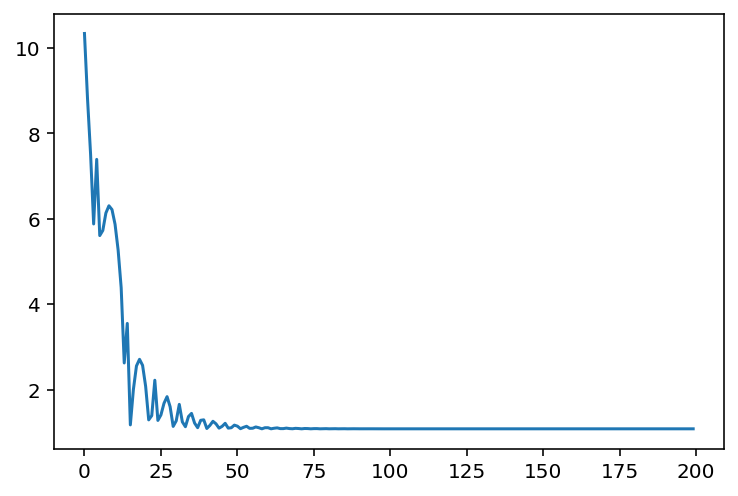

In [303]:
plt.plot(losses)

In [304]:
@tf.function
def compute_loss(batch_y0, batch_yN, neuralodes):
    pred_y = neuralodes.forward(batch_y0)  # This finds the predicted yNs
    loss = tf.reduce_mean(input_tensor=(pred_y - batch_yN)**2)
    return loss

In [305]:
temp_model = ODEModel_pre()
neural_ode_temp = NeuralODE(temp_model, t=t_in)


In [306]:
x =  np.linspace(0,0.5,30)
y =  np.linspace(0,0.5,30)

zs = []
M, B = np.meshgrid(x,y)
for mp, bp in tqdm(zip(np.ravel(M), np.ravel(B))):
    w_temp = np.resize(np.array([mp, bp]),(2,1))
    temp_model.trainable_weights[0].assign(w_temp) 
    zs.append(compute_loss(batch_y0,batch_yN,neural_ode_temp))
            
zs = np.array(zs)
Z = zs.reshape(M.shape)

900it [00:13, 66.65it/s]


Text(0, 0.5, 'gamma')

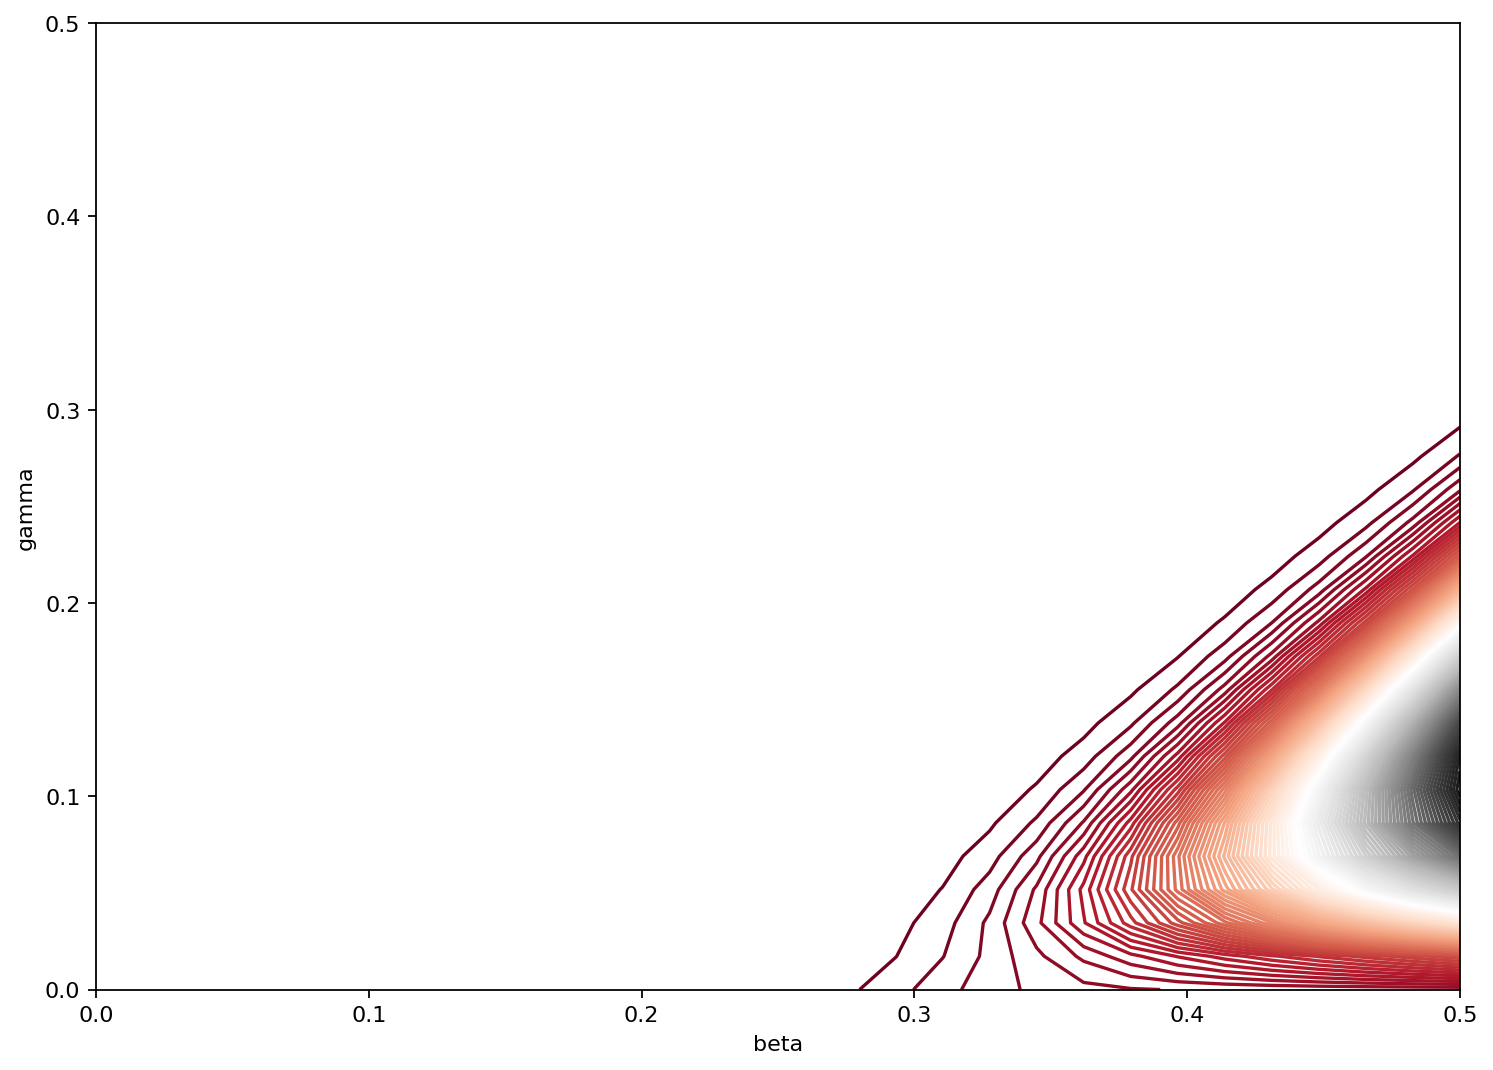

In [307]:
fig = plt.figure(figsize=(11, 8), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)

plt.contour(M,B,Z, 100, cmap='RdGy')
ax.set_xlabel('beta')
ax.set_ylabel('gamma')



Text(0.5, 0, 'loss')

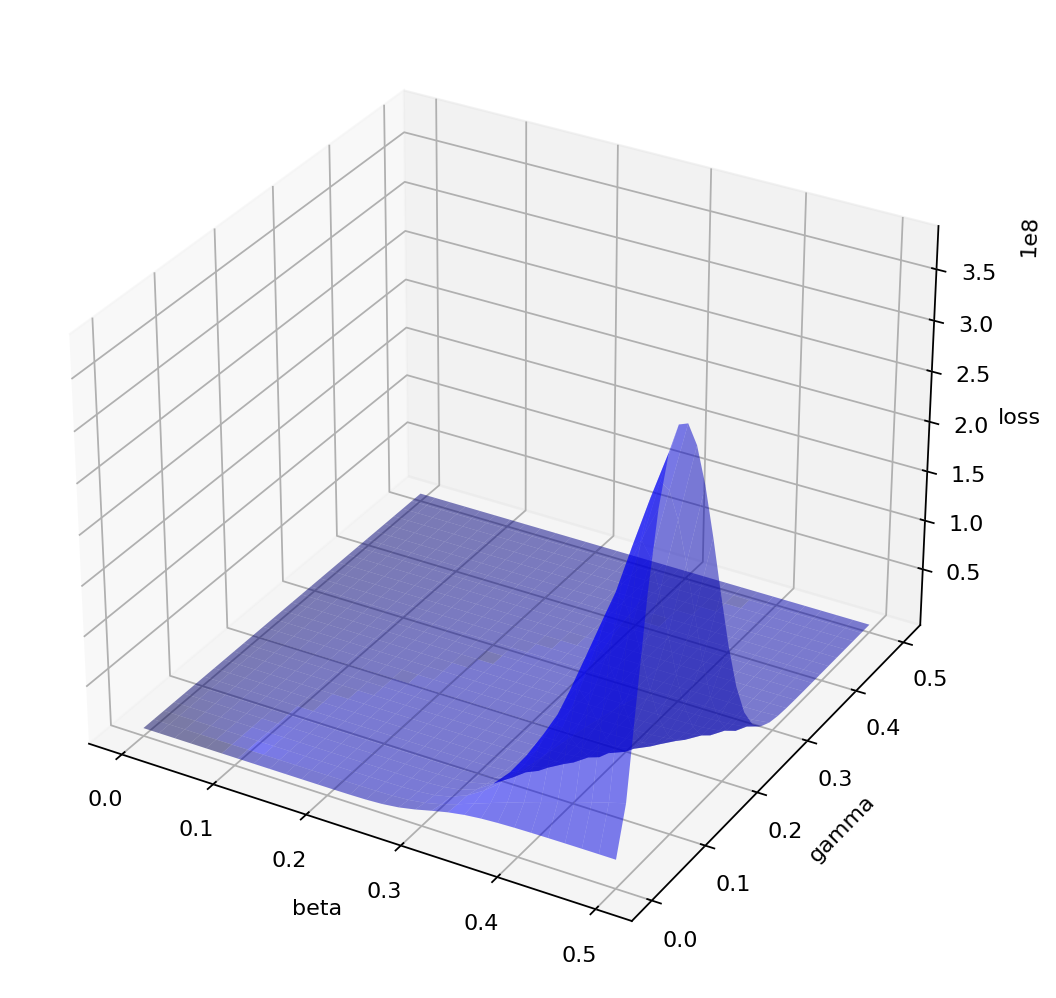

In [308]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(M, B, Z, rstride=1, cstride=1, color='b', alpha=0.5)
ax.set_xlabel('beta')
ax.set_ylabel('gamma')
ax.set_zlabel('loss')

In [309]:
italy.iloc[0]

Date           2020-09-19 00:00:00
Infected                       704
Dead                            24
Recovered                      909
Susceptible            6.03173e+07
Name: 0, dtype: object

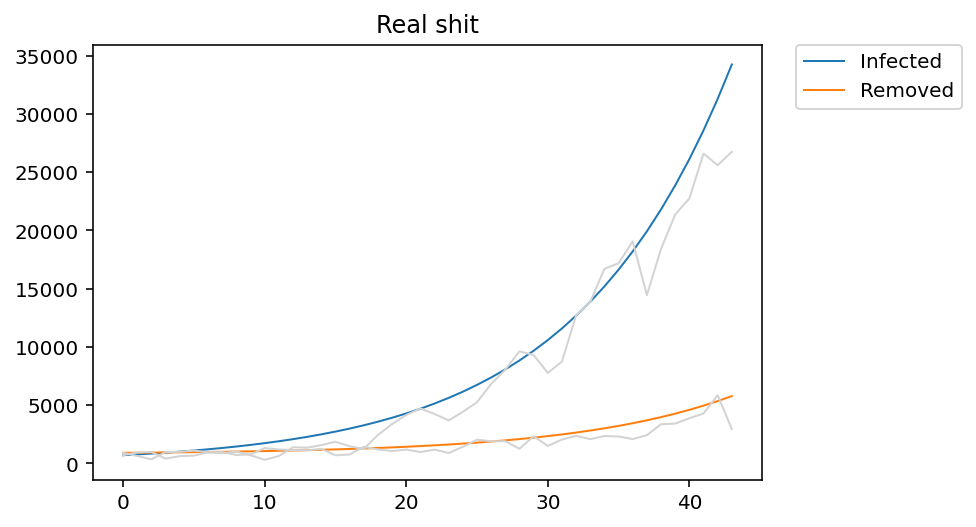

In [310]:
#parameters_pre = [0.2,0.05]

simul_yy =  odeint(SIR, [N,704,909], t_grid, args=tuple(np.reshape(parameters_pre,(1,-1))[0]))
plot_traj(simul_yy)
plot_traj_gray(nonorm_y)

In [311]:
w_temp = np.resize(np.array([0.105,0.02]),(2,1))
temp_model.trainable_weights[0].assign(w_temp) 
compute_loss(batch_y0,batch_yN,neural_ode_temp)

<tf.Tensor: shape=(), dtype=float32, numpy=1.7231101>

In [312]:
initial_weight = parameters_pre  # We initialize the weights with the parameters found in preconditioning
#print(initial_weight.shape, "here")


class ODEModel(tf.keras.Model):
    def __init__(self):
        super(ODEModel, self).__init__()
        self.Weights = tf.Variable(tf.random.normal([num_param, 1], dtype=tf.float32)*0.01, dtype=tf.float32)
        # Initializer, initializes the weight to normal random variables with sd = 0.01

    def call(self, inputs, **kwargs):
        t, y = inputs
        h = y
        S = h[:, 0:1] * sigma_s
        I = h[:, 1:2] * sigma_i
        R = h[:, 2:3] * sigma_r

        # ma che sintassi di merda -> facciamolo adattativo

        p1 = self.Weights[0]
        p2 = self.Weights[1]
        
        dS = - p1 * I * S / N 
        dI = p1 * I * S / N - p2 * I 
        dR = p2 * I 

        dzdt = [dS, dI, dR]
        
        h_out = tf.concat([dS/sigma_s, dI/sigma_i, dR/sigma_r], 1)
        return h_out
    
model = ODEModel()
neural_ode = NeuralODE(model, t=t_in)  # We assign to NeuralODE the just created model and the time grid  between t0 and t1

temp_model = ODEModel()
neural_ode_temp = NeuralODE(temp_model, t=t_in)

@tf.function
def compute_gradients_and_update(batch_y0, batch_yN): 
    """Takes start positions (x0, y0) and final positions (xN, yN)"""
    pred_y = neural_ode.forward(batch_y0)  # This finds the predicted yNs
    with tf.GradientTape() as g:
        g.watch(pred_y)
        loss = tf.reduce_sum(input_tensor=(pred_y - batch_yN)**2)  # This creates the loss function

    dLoss = g.gradient(loss, pred_y)  # This computes the gradient of the loss function
    h_start, dfdh0, dWeights = neural_ode.backward(pred_y, dLoss)  # This applies the gradient descent to find
    # the updates for the weights

    return loss, dWeights

In [313]:
def adaptive_gaussian_sampling(true_center, loc, scale, quantile_1, quantile_2):
    if ((sps.norm.cdf(true_center, loc=loc, scale=scale) < quantile_1) | (sps.norm.cdf(true_center, loc=loc, scale=scale) > quantile_2)):
        par = npr.uniform(0,1)
        a = 0
        b = 0
        if true_center > loc:
            a = ((loc + par*(true_center-loc)) - loc)/scale
            b = float('inf')
            w_temp = sps.truncnorm.rvs(a, b, loc=loc, scale=scale)
        else:
            a = ((loc + par*(true_center-loc)) - loc)/scale
            b = -float('inf')
            w_temp = sps.truncnorm.rvs(b, a, loc=loc, scale=scale)
    else:
        w_temp = npr.normal(loc, scale)
    
    return(w_temp)

In [314]:
def border_estimates_e_abc(eps, niters):
    
    
    # This function estimates the borders of the region containing the eps-approximate posterior through niters 
    #  iterations. It uses the empirical sampling method to get nearer to the correct acceptance region.
    #  This is only used to estimate borders, though it can estimate also the parameters in order to avoid 
    #  biases in the estimation.

    import scipy.stats as sps

    model.trainable_weights[0].assign(parameters_pre)
    initial_loss, _ = compute_gradients_and_update(batch_y0, batch_yN)   # The result we obtained from the simulation of the model
    initial_loss = 0
    
    # temp_model.trainable_weights[0].assign(parameters_pre) 
    # initial_loss = compute_loss(batch_y0, batch_yN, neural_ode_temp) 
    # print(initial_loss)

    naccepted = 0
    
    parameters = np.zeros((niters, para_num))  # book keeping the parameters
    lambdalist = np.zeros((niters, 1))  # book keeping the loggamma
    loss = []

    lambda_temp = 0
    w_temp = 0

    for i in tqdm(range(niters)):

        lambda_temp = npr.uniform(low = 0, high = 1.5)

        WW = model.trainable_weights[0].numpy()

        w_temp_1 = 0
        w_temp_2 = 0

        alpha_quant = 0.25 # crasha ogni volta, ogni volta dopo un numero differente di iterazioni.
        # trovato su stackoverflow:
                #I've encountered the same problem as well. 
                #The thing is that the lower bound a is above (or close to) the 99% quantile of the Normal distribution.
                #Thus the truncation causes scipy to crush.
                #The only solution I came out with is to check before truncation if myclip_a is above the 99% quantile and
                #if so avoid the update. I hope that someone will find a better solution than mine!

        w_temp_1 = adaptive_gaussian_sampling(WW[0], 0, 1/lambda_temp, alpha_quant, 1-alpha_quant)
        w_temp_2 = adaptive_gaussian_sampling(WW[1], 0, 1/lambda_temp, alpha_quant, 1-alpha_quant)

        w_temp = np.resize([w_temp_1, w_temp_2], (2,1))
        temp_model.trainable_weights[0].assign(w_temp) 

        # After the sampling from the prior we go on by simulating the model
        # sim_trajectories = simulate_trajectories_from_theta_hat(model, w_temp)

        sim_loss = compute_loss(batch_y0, batch_yN, neural_ode_temp) # ma qua va guardato modello nuovo senza aggiornare
        loss.append(sim_loss)

        # if abc_distance(initial_trajectories, sim_trajectories) < eps:
        if np.abs(initial_loss - sim_loss) < (eps + npr.uniform()*eps*1/3):
            parameters[naccepted:naccepted+1, :] = np.transpose(w_temp)
            lambdalist[naccepted:naccepted+1] = lambda_temp
            naccepted += 1

    print('Acceptance rate: ', naccepted / niters)

    parameters = parameters[0:naccepted,:]
    lambdalist = lambdalist[0:naccepted,:]
    
    # attenzione, problem specific
    border1 = np.min(parameters[:,0])
    border2 = np.min(parameters[:,1])

    return([border1, border2])

In [315]:
def e_abc_gaussian_sampling(true_center, loc, scale, border):
    
    # This function performs the empirical sampling from our method when the "true center" is too far from
    #  the center of the prior.
    
    if ((sps.norm.cdf(true_center, loc=loc, scale=scale) < 0.25) | (sps.norm.cdf(true_center, loc=loc, scale=scale) > 0.75)):
        a = 0
        b = 0
        if true_center > loc:
            a = (border - loc)/scale
            b = float('inf')
            w_temp = sps.truncnorm.rvs(a, b, loc=loc, scale=scale)
        else:
            a = (border - loc)/scale
            b = -float('inf')
            w_temp = sps.truncnorm.rvs(b, a, loc=loc, scale=scale)
    else:
        w_temp = npr.normal(loc, scale)
    
    return(w_temp)

In [321]:
def preprocessing_e_abc(eps, niters, borders):

    # This function performs the first sampling from the region defined through the borders estimating function and
    #  returns the estimated parameters and the initializing weights, ([1,1,1,...,1] normalized)
    
    import scipy.stats as sps

    model.trainable_weights[0].assign(parameters_pre)
    initial_loss, _ = compute_gradients_and_update(batch_y0, batch_yN)   # The result we obtained from the simulation of the model
    initial_loss = 0
    
    # temp_model.trainable_weights[0].assign(parameters_pre) 
    # initial_loss = compute_loss(batch_y0, batch_yN, neural_ode_temp) 
    # print(initial_loss)

    niters = 50000
    naccepted = 0
    eps = 0.05 # To be determined, it is a hyperparameter

    parameters = np.zeros((niters, para_num))  # book keeping the parameters
    lambdalist = np.zeros((niters, 1))  # book keeping the loggamma
    loss = []

    lambda_temp = 0
    w_temp = 0

    for i in tqdm(range(niters)):

        # We will consider here the standard Ridge model for data approximation

        lambda_temp = npr.uniform(low = 0, high = 1.5)

        WW = model.trainable_weights[0].numpy()

        w_temp_1 = 0
        w_temp_2 = 0

        # alpha_quant = 0.15

        w_temp_1 = e_abc_gaussian_sampling(WW[0], 0, 1/lambda_temp, borders[0])
        w_temp_2 = e_abc_gaussian_sampling(WW[1], 0, 1/lambda_temp, borders[1])

        w_temp = np.resize([w_temp_1, w_temp_2], (2,1))
        temp_model.trainable_weights[0].assign(w_temp) 

        # After the sampling from the prior we go on by simulating the model
        # sim_trajectories = simulate_trajectories_from_theta_hat(model, w_temp)
        

        sim_loss = compute_loss(batch_y0, batch_yN, neural_ode_temp) # ma qua va guardato modello nuovo senza aggiornare
        loss.append(sim_loss)

        # if abc_distance(initial_trajectories, sim_trajectories) < eps:
        if np.abs(initial_loss - sim_loss) < (eps + npr.uniform()*eps*1/3):
            parameters[naccepted:naccepted+1, :] = np.transpose(w_temp)
            lambdalist[naccepted:naccepted+1] = lambda_temp
            naccepted += 1

    print('Acceptance rate: ', naccepted / niters)

    parameters = parameters[0:naccepted,:]
    lambdalist = lambdalist[0:naccepted,:]

    weights = np.ones(parameters.shape[0])/parameters.shape[0]
    
    return(parameters, weights)

In [322]:
def compute_weights_abc_smc(w, loc, scale, prev_w, prev_p, scale_kernel):
    
    # This function computes the weights associated to each parameter as described in https://arxiv.org/pdf/1106.6280.pdf
    
    prob_w = 1
    for i in range(2):
        prob_w *= sps.norm.pdf(w[i], loc=loc, scale=scale)
    
    previous_w = 0
    for i in range(prev_w.shape[0]):
        kern_w = 1
        for j in range(2):
            kern_w *= sps.norm.pdf(w[j], loc=prev_p[i,j], scale=scale_kernel[j])
        previous_w += prev_w[i]*kern_w
    
    return(prob_w/previous_w)

In [323]:
def normalize_weights(weights):
    
    # This function performs the normalization of weights
    
    tot_weight = np.sum(weights)
    return(weights/tot_weight)

In [324]:
def sample_abc_smc_element(parameters, weights):
    
    # This function samples from the previous population according to the specified weights
    
    elements = np.arange(parameters.shape[0])
    idx = np.random.choice(elements, 1, p=weights)
    return(parameters[idx,])

In [325]:
def perturbation_kernel(sdev):
    
    # This function returns the perturbation from a Gaussian kernel with the specified standard deviation
    
    return([np.random.randn()*sdev[0], np.random.randn()*sdev[1]])

In [326]:
def sample_abc_smc(eps, niters, kernel_std, old_parameters, weights): 
    
    # This function returns the sampling according to the ABC-SMC with the weights associated to old parameters
    # specified in weights and the old parameters specified in old_parameters
    
    import scipy.stats as sps

    # We now start the Bayesian framework
    # We will compute the Approximate Bayesian Computation approximation from the posterior
    model.trainable_weights[0].assign(parameters_pre)
    initial_loss, _ = compute_gradients_and_update(batch_y0, batch_yN)   # The result we obtained from the simulation of the model
    initial_loss = 0
    # temp_model.trainable_weights[0].assign(parameters_pre) 
    # initial_loss = compute_loss(batch_y0, batch_yN, neural_ode_temp) 
    # print(initial_loss)
    # In teoria questa loss è un minimo locale, quindi dovrebbe essere la più piccola. Più si è vicini a questa
    # loss con i theta individuati e meglio è per la simulazione.
    # In alternativa alla loss, per la quale non riesco a trovare giustificazioni teoriche assolutamente convincenti
    # si possono prendere le traiettorie e calcolare lo scostamento, questo sarebbe un approccio "esatto", ma computazionalmente
    # sbatti...

    naccepted = 0
    parameters = np.zeros((niters, para_num))  # book keeping the parameters
    lambdalist = np.zeros((niters, 1))  # book keeping the loggamma
    loss = []
    new_weights = []

    lambda_temp = 0
    w_temp = 0

    for i in tqdm(range(niters)):

        # Extracting from previous population with specified weights
        w_temp = sample_abc_smc_element(old_parameters, weights)
        
        # Perturbating with the gaussian Kernel
        pert = perturbation_kernel(kernel_std)
        w_temp = w_temp + pert

        # Pipeline to accept/reject the new point
        w_temp = np.resize(w_temp, (2,1))
        temp_model.trainable_weights[0].assign(w_temp) 

        sim_loss = compute_loss(batch_y0, batch_yN, neural_ode_temp) 
        loss.append(sim_loss)

        # if abc_distance(initial_trajectories, sim_trajectories) < eps:
        if np.abs(initial_loss - sim_loss) < (eps + npr.uniform()*eps*1/3):
            parameters[naccepted:naccepted+1, :] = np.transpose(w_temp)
            lambdalist[naccepted:naccepted+1] = lambda_temp
            naccepted += 1
            lambda_temp = npr.uniform(low = 0, high = 1.5)
            new_weights.append(compute_weights_abc_smc(w_temp, 0, 1/lambda_temp, weights, old_parameters, kernel_std)) 
            
        

    print('Acceptance rate: ', naccepted / niters)

    new_weights = normalize_weights(new_weights)
    new_weights = new_weights.reshape(naccepted)
    
    parameters = parameters[0:naccepted,:]
    lambdalist = lambdalist[0:naccepted,:]
    
    return(parameters, new_weights)

In [327]:
import scipy.stats as sps

eps = 0.6
niters = 3000
std_dev_start = [0.05, 0.05]

print("Borders estimation start...")
borders = border_estimates_e_abc(eps, 5*niters)
print("Borders estimation completed, starting preprocessing...")
start, start_weights = preprocessing_e_abc(eps, 5*niters, borders)
print("Preprocessing completed, starting ABC-SMC")
parameters, weights = sample_abc_smc(eps, 5*niters, std_dev_start, start, start_weights)
parameters, weights = sample_abc_smc(eps/2, 5*niters, std_dev_start, parameters, weights)
parameters, weights = sample_abc_smc(eps/3, 5*niters, np.std(parameters, axis=0), parameters, weights)
parameters, weights = sample_abc_smc(eps/4, 5*niters, np.std(parameters, axis=0), parameters, weights)
parameters, weights = sample_abc_smc(eps/5, 25*niters, np.std(parameters, axis=0), parameters, weights)

Borders estimation start...


  0%|▏                                                                            | 25/15000 [00:03<3:52:57,  1.07it/s]<ipython-input-319-f1b7c35abd34>:58: RuntimeWarning: invalid value encountered in less
  if np.abs(initial_loss - sim_loss) < (eps + npr.uniform()*eps*1/3):
  0%|                                                                                | 6/50000 [00:00<15:39, 53.24it/s]

Acceptance rate:  0.027
Borders estimation completed, starting preprocessing...


  0%|                                                                               | 70/50000 [00:01<13:01, 63.90it/s]<ipython-input-321-fd2237a89045>:54: RuntimeWarning: invalid value encountered in less
  if np.abs(initial_loss - sim_loss) < (eps + npr.uniform()*eps*1/3):
  0%|                                                                                        | 0/15000 [00:00<?, ?it/s]

Acceptance rate:  0.0
Preprocessing completed, starting ABC-SMC


ValueError: 'a' cannot be empty unless no samples are taken